In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
from sklearn.grid_search import GridSearchCV

import xgboost as xgb
import datetime
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.cross_validation import train_test_split
#now = datetime.datetime.now()

train = pd.read_csv('./input/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('./input/test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('./input/macro.csv', parse_dates=['timestamp'])

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

id_test = test.id
#multiplier = 0.969

def RMSLE_(y_val, y_val_pred):
    return np.sqrt(np.mean((np.log(y_val+1)-np.log(y_val_pred+1))**2))
RMSLE = make_scorer(RMSLE_, greater_is_better=False) 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [3]:
#clean data
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
train.product_type.value_counts(normalize= True)
test.product_type.value_counts(normalize= True)
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN
train.floor.describe(percentiles= [0.9999])
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
train.material.value_counts()
test.material.value_counts()
train.state.value_counts()
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
test.state.value_counts()


2.0    2662
1.0    2266
3.0    1913
4.0     127
Name: state, dtype: int64

In [4]:
# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

In [5]:
train_lat_long=pd.read_csv("./input/train_lat_lon.csv")
test_lat_long=pd.read_csv("./input/test_lat_lon.csv")
train_lat_long.head()

,key,id,lat,lon,tolerance_m
0,0.013626182:9.625238462:12.34154117:Ochakovo-M...,11054,55.682829,37.416212,5
1,0.013626182:9.625238462:12.34154117:Ochakovo-M...,19359,55.682829,37.416212,5
2,0.013626182:9.625238462:12.34154117:Ochakovo-M...,21535,55.682829,37.416212,5
3,0.013626182:9.625238462:12.34154117:Ochakovo-M...,23401,55.682829,37.416212,5
4,0.013626182:9.625238462:12.34154117:Ochakovo-M...,23613,55.682829,37.416212,5


In [6]:
train=train.merge(train_lat_long[["id","lat","lon"]],left_on='id',right_on='id')
test=test.merge(test_lat_long[["id","lat","lon"]],left_on='id',right_on='id')
train.loc[train['id']==11054]

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [7]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

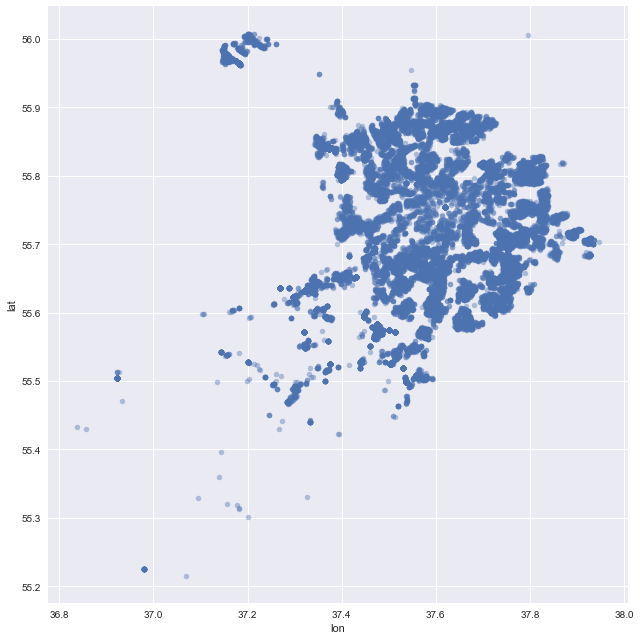

In [8]:
sns.lmplot(x="lon",y="lat",scatter_kws={'alpha':.4,'s':30}, size=9, fit_reg=False, data=train)
axes=plt.gca()

In [9]:
import math
def cart2rho(x, y):
    rho = np.sqrt(x**2 + y**2)
    return rho


def cart2phi(x, y):
    phi = np.arctan2(y, x)
    return phi

#center long/lat of moscow: (37.6173, 55.7558)
def rotation_x(row, alpha):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return x*math.cos(alpha) + y*math.sin(alpha)


def rotation_y(row, alpha):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return y*math.cos(alpha) - x*math.sin(alpha)


def add_rotation(degrees, df):
    namex = "rot" + str(degrees) + "_X"
    namey = "rot" + str(degrees) + "_Y"

    df['num_' + namex] = df.apply(lambda row: rotation_x(row, math.pi/(180/degrees)), axis=1)
    df['num_' + namey] = df.apply(lambda row: rotation_y(row, math.pi/(180/degrees)), axis=1)

    return df

def add_dist_to_center(row):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return cart2phi(x,y)

def operate_on_coordinates(tr_df, te_df):
    for df in [tr_df, te_df]:
        #polar coordinates system
#         df["num_rho"] = df.apply(lambda x: cart2rho(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         df["num_phi"] = df.apply(lambda x: cart2phi(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         #rotations
        for angle in [15,30,45,60]:
            df = add_rotation(angle, df)
        df['dist_to_center']=df.apply(lambda row: add_dist_to_center(row), axis=1)

    return tr_df, te_df

train, test= operate_on_coordinates(train, test)

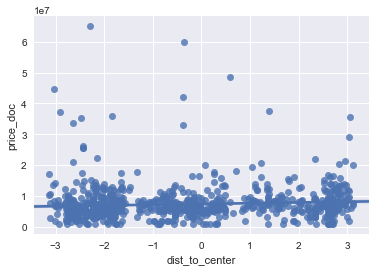

In [13]:
sns.regplot(data=train.sample(1000),x="dist_to_center",y="price_doc")

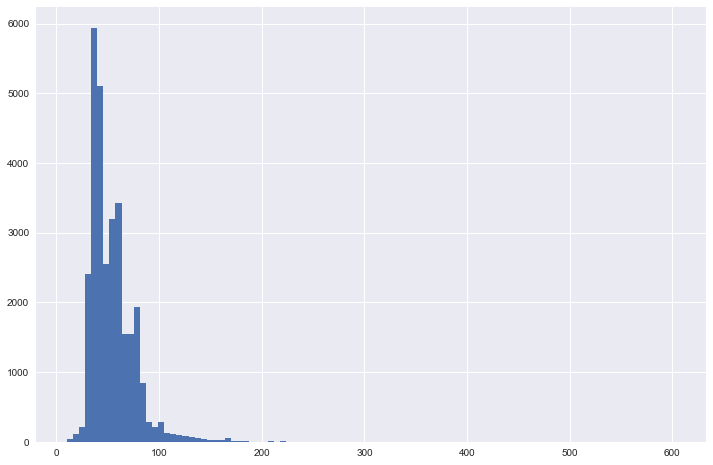

In [11]:
train['full_sq'].hist(bins=100, figsize=(12,8))

In [12]:
y_train = train["price_doc"]
X_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

for c in X_train.columns:
    if X_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[c].values)) 
        X_train[c] = lbl.transform(list(X_train[c].values))
        #X_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)  

In [13]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}
num_rounds=400

X_fit, X_val, y_fit, y_val=train_test_split(X_train[:], y_train[:], test_size=0.2, random_state=123)
xgfit = xgb.DMatrix(X_fit, label=y_fit)
xgval = xgb.DMatrix(X_val, label=y_val)
watchlist = [ (xgfit,'train'), (xgval, 'test') ]
clfCV = xgb.train(xgb_params, xgfit, num_rounds)
#clfCV = xgb.train(xgb_params, xgfit, num_rounds, watchlist, early_stopping_rounds=20)

y_val_pred = clfCV.predict(xgval)
RMSLE_(y_val,y_val_pred)


0.44153281251502002

In [10]:
xgbreg = xgb.XGBRegressor()
param_grid = {
       #'n_estimators': [500],
       'learning_rate': [.05], #[ .045, 0.05, .055],
       'max_depth': [5],
       'subsample': [.7], #[ .65, 0.7, .75],
       'colsample_bytree': [.7],#[.65, 0.7, 0.75],
        'seed':np.arange(20,50)
}
model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.best_params_)
print('Best CV Score:')
print(-model.best_score_)

# eXtreme Gradient Boosting regression...
# Best Params:
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5}
# Best CV Score:
# 0.468277454751

NameError: name 'X_train' is not defined

param_grid = {'eta':[.05], 'num_round':[500], 'subsample':[.7], 'colsample_bytree':[.7], \
              'max_depth':[5], 'seed':[2017,213,5]}
for eta in param_grid['eta']:
    for subsample in param_grid['subsample']:
        for colsample_bytree in param_grid['colsample_bytree']:
            for max_depth in param_grid['max_depth']:
                for seed in param_grid['seed']:
                    for num_rounds in param_grid['num_round']:
                        model=xgbClass(colsample_bytree=colsample_bytree, eta=eta, eva_metric='rmse', \
                                       subsample=subsample, max_depth=max_depth, seed=seed,\
                                       objective='reg:linear', num_class=1,num_rounds=num_rounds,\
                                       early_stopping_rounds=20)
                        score=CVScore(model=model, n_splits=3, my_score=RMSLE, X_train=X_train,\
                                  y_train=y_train)
                        del model
                        print('eta={}, subsample={}, colsample_bytree={}, max_depth={}, seed={}, score={}, num_rounds={}'.\
                          format(eta, subsample, colsample_bytree, max_depth, seed, score, num_rounds))

[0]	train-rmse:8.18181e+06	test-rmse:8.18735e+06
[50]	train-rmse:2.43936e+06	test-rmse:2.79808e+06
[100]	train-rmse:2.11594e+06	test-rmse:2.60068e+06
[150]	train-rmse:2.00235e+06	test-rmse:2.55969e+06
[200]	train-rmse:1.91925e+06	test-rmse:2.53881e+06
[250]	train-rmse:1.84674e+06	test-rmse:2.524e+06
[300]	train-rmse:1.78525e+06	test-rmse:2.51535e+06
[350]	train-rmse:1.73193e+06	test-rmse:2.51249e+06
[400]	train-rmse:1.68444e+06	test-rmse:2.50904e+06
[450]	train-rmse:1.63789e+06	test-rmse:2.50568e+06


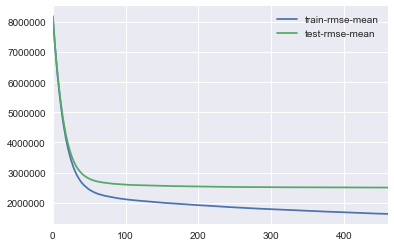

In [14]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 5
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(x_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [15]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})



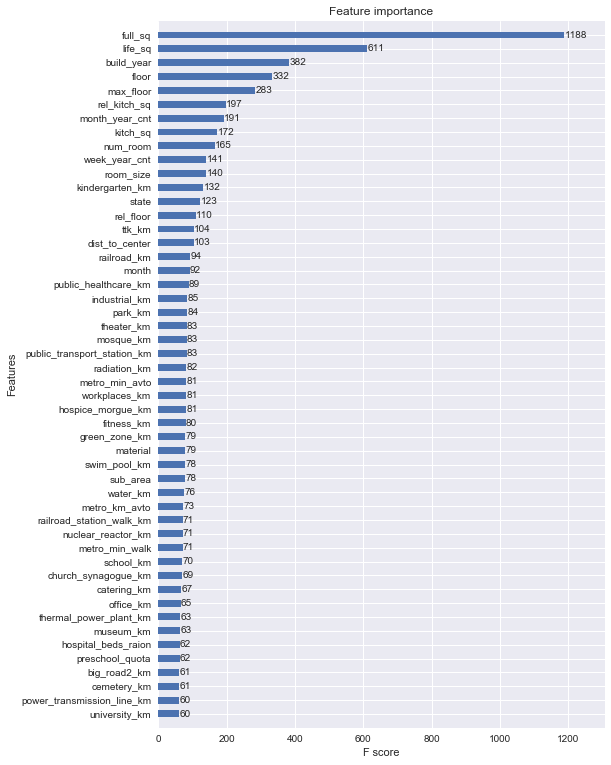

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [17]:
output.to_csv('submission_may31_1.csv', index=False)